# Distance-Aware Bernoulli Thompson Sampling  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class Environment():
  def __init__(self, num_stations):
    self.num_stations = num_stations
    self.generate_true_probabilities()
    
  def generate_true_probabilities(self):
    self.thetas = np.random.uniform(0,1,self.num_stations)

  def get_reward(self, station):
    return np.random.binomial(1, self.thetas[station], size=1)[0]

class Station():
  def __init__(self,loc):
    self.alpha = 1
    self.beta = 1
    self.loc = np.array(loc)

  def update_alpha(self):
    self.alpha += 1
  
  def update_beta(self):
    self.beta += 1


In [2]:
def run_experiment(num_iters, locs , c_vals):

  num_stations = len(locs)
  env = Environment(num_stations)

  num_c = len(c_vals)

  posterior_means = np.zeros((num_c, num_iters, num_stations))
  actions = np.zeros((num_c, num_iters))
  error = np.zeros((num_c, num_iters, num_stations))

# for loop through different c values
  for j in range(num_c):

    c = c_vals[j]
    robot_loc = np.array([5,5])
    stations = []
    for i in range(num_stations):
      stations.append(Station(locs[i]))

    for t in range(num_iters): 

      posterior_samples = np.zeros((num_stations))
      dists = np.zeros((num_stations))
      Q = np.zeros((num_stations))

      # update and sample from posteriors
      for i in range(num_stations):
        posterior_means[j][t][i] = stations[i].alpha / (stations[i].alpha + stations[i].beta)
        error[j][t][i] = np.abs(env.thetas[i] - posterior_means[j][t][i])
        posterior_samples[i] = np.random.beta(stations[i].alpha, stations[i].beta, size=1)[0]
        
      # select user with based on sampled probability and proximity to robot
      for i in range(num_stations):
        dists[i] = np.linalg.norm(stations[i].loc - robot_loc)
        Q[i] = c * posterior_samples[i] + (1 - c) * (1 - np.linalg.norm(dists[i]))
      chosen_station = np.argmax(Q)
      robot_loc = stations[chosen_station].loc
      
      actions[j][t] = chosen_station

      # execute task and observe result (reward or no reward)
      r = env.get_reward(chosen_station)

      # update posterior distributions
      if r:
        stations[chosen_station].update_alpha()
      else:
        stations[chosen_station].update_beta()

  return env, stations, posterior_means, actions, error

In [3]:
def get_station_labels(num_stations):
  station_labels = []
  for i in range(num_stations):
    station_labels.append(f'Station {i}')
  return station_labels

def plot_map(stations):
  station_labels = get_station_labels(num_stations)
  for i in range(len(stations)):
    plt.scatter(stations[i].loc[0],stations[i].loc[1])
  plt.scatter(5,5)
  station_labels.append('Robot')
  plt.legend((station_labels))
  plt.title('Map of Factory Configuration')

def get_df(num_stations, env, posterior_means):
  station_labels = get_station_labels(num_stations)
  df = pd.DataFrame([env.thetas, posterior_means[num_iters-1]])
  df.index = ["True Probability", "Estimated Mean of Distribution"]
  df.columns = [get_station_labels(num_stations)]
  return df

### Simulation with 4 Stations and 100 Iterations

In [552]:
num_iters = 100
num_stations = 4
locs = np.random.randint(11, size=[num_stations, 2])
num_c = 4
c_vals = np.array([1.0,0.9,0.8,0.7])
env, stations, posterior_means, actions, error = run_experiment(num_iters, locs, c_vals)

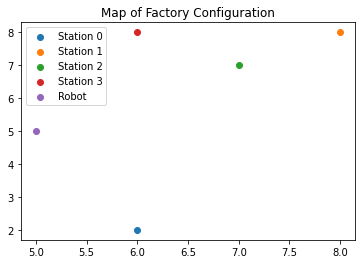

In [553]:
plot_map(stations)

In [554]:
data = [env.thetas]
idx_label = ['True Probability']
for i in range(num_c):
  data.append(posterior_means[i][num_iters-1])
  idx_label.append(f'Estimated Probability with c = {c_vals[i]}')
df = pd.DataFrame(data)
df.index = idx_label
df.columns = [get_station_labels(num_stations)]
df

,Station 0,Station 1,Station 2,Station 3
True Probability,0.934129,0.976984,0.453919,0.536872
Estimated Probability with c = 1.0,0.918919,0.964912,0.666667,0.500000
Estimated Probability with c = 0.9,0.500000,0.948454,0.600000,0.666667
Estimated Probability with c = 0.8,0.500000,0.969697,0.333333,0.666667
Estimated Probability with c = 0.7,0.500000,0.500000,0.500000,0.514851


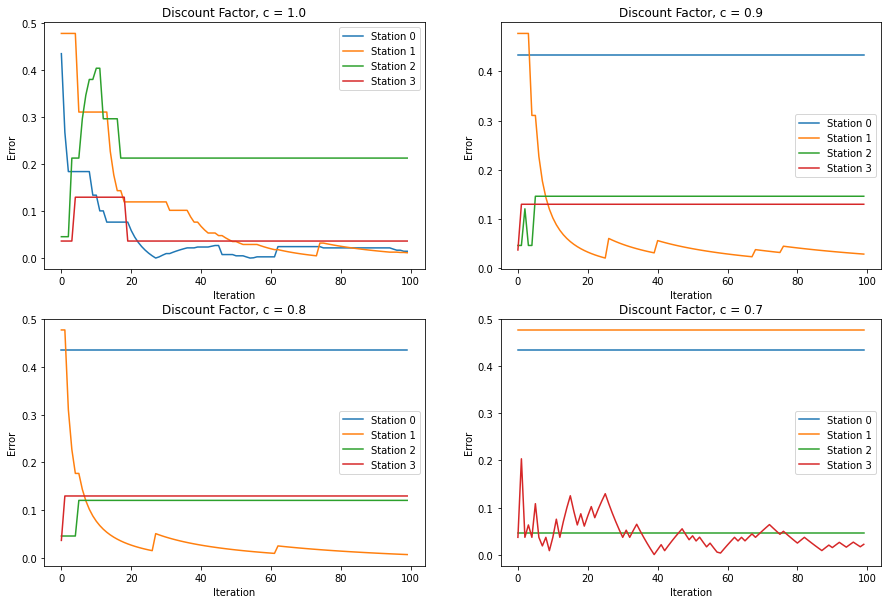

In [559]:
x = int(num_c/2)
labels = get_station_labels(num_stations)
fig, ax = plt.subplots(x, x, figsize=(15, 10))
k = 0
for i in range(x):
  for j in range(x):
    ax[i, j].plot(error[k])
    ax[i, j].legend(labels)
    ax[i, j].set_xlabel('Iteration')
    ax[i, j].set_ylabel('Error')
    ax[i, j].set_title(f'Discount Factor, c = {c_vals[k]}')
    k = k + 1

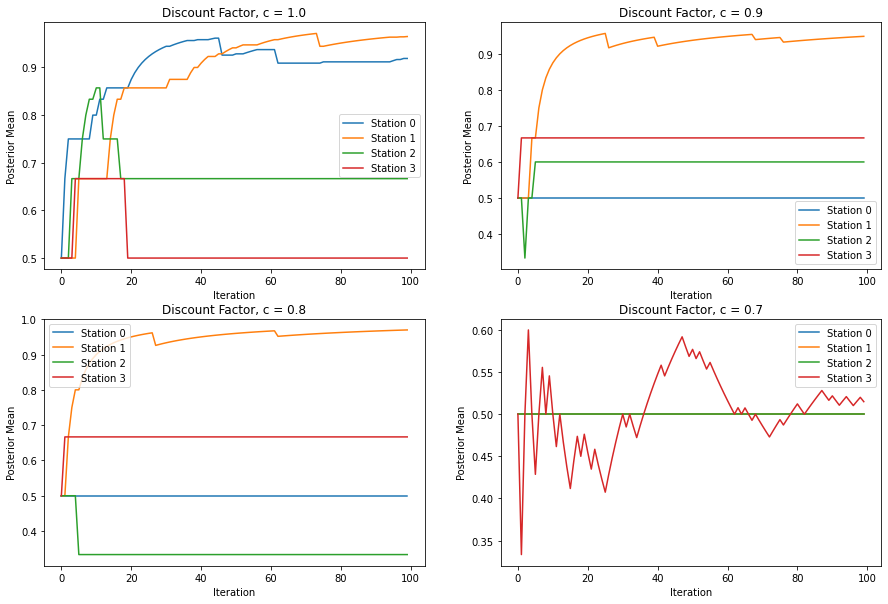

In [560]:
fig, ax = plt.subplots(x, x, figsize=(15, 10))
k = 0
for i in range(x):
  for j in range(x):
    ax[i, j].plot(posterior_means[k])
    ax[i, j].legend(labels)
    ax[i, j].set_xlabel('Iteration')
    ax[i, j].set_ylabel('Posterior Mean')
    ax[i, j].set_title(f'Discount Factor, c = {c_vals[k]}')
    k = k + 1

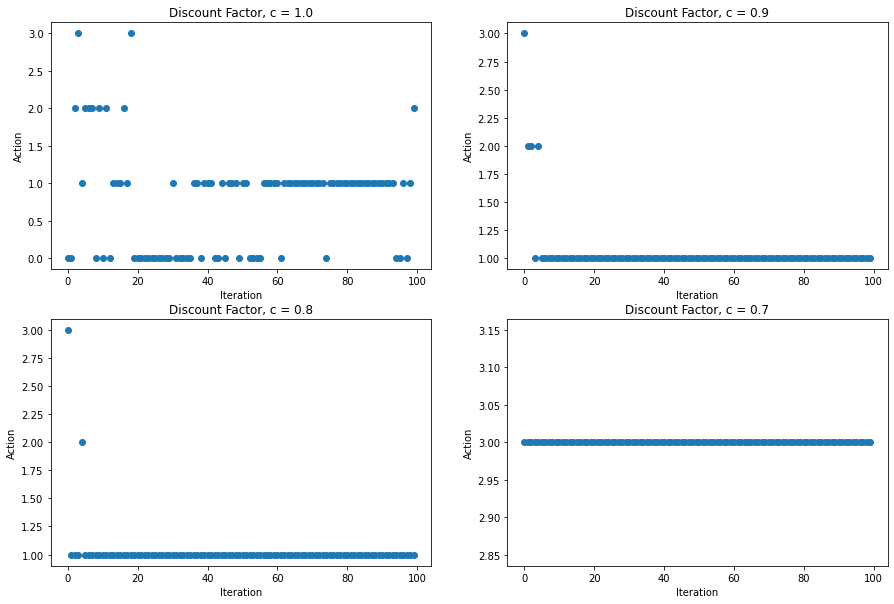

In [561]:
fig, ax = plt.subplots(x, x, figsize=(15, 10))
k = 0
for i in range(x):
  for j in range(x):
    ax[i, j].scatter(np.arange(num_iters), actions[k])
    ax[i, j].set_xlabel('Iteration')
    ax[i, j].set_ylabel('Action')
    ax[i, j].set_title(f'Discount Factor, c = {c_vals[k]}')
    k = k + 1

### Simulation with 8 Stations and 200 Iterations

In [26]:
num_iters = 200
num_stations = 8
locs = np.random.randint(11, size=[num_stations, 2])
num_c = 4
c_vals = np.array([1.0,0.9,0.8,0.7])
env, stations, posterior_means, actions, error = run_experiment(num_iters, locs, c_vals)

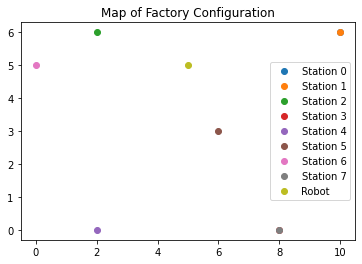

In [27]:
plot_map(stations)

In [28]:
data = [env.thetas]
idx_label = ['True Probability']
for i in range(num_c):
  data.append(posterior_means[i][num_iters-1])
  idx_label.append(f'Estimated Probability with c = {c_vals[i]}')
df = pd.DataFrame(data)
df.index = idx_label
df.columns = [get_station_labels(num_stations)]
df

,Station 0,Station 1,Station 2,Station 3,Station 4,Station 5,Station 6,Station 7
True Probability,0.937817,0.760412,0.277655,0.568218,0.867845,0.183881,0.416767,0.040799
Estimated Probability with c = 1.0,0.870370,0.842105,0.333333,0.714286,0.833333,0.250000,0.285714,0.200000
Estimated Probability with c = 0.9,0.500000,0.500000,0.375000,0.500000,0.500000,0.333333,0.526882,0.500000
Estimated Probability with c = 0.8,0.500000,0.500000,0.318182,0.500000,0.500000,0.500000,0.433962,0.500000
Estimated Probability with c = 0.7,0.500000,0.500000,0.500000,0.500000,0.500000,0.189055,0.500000,0.500000


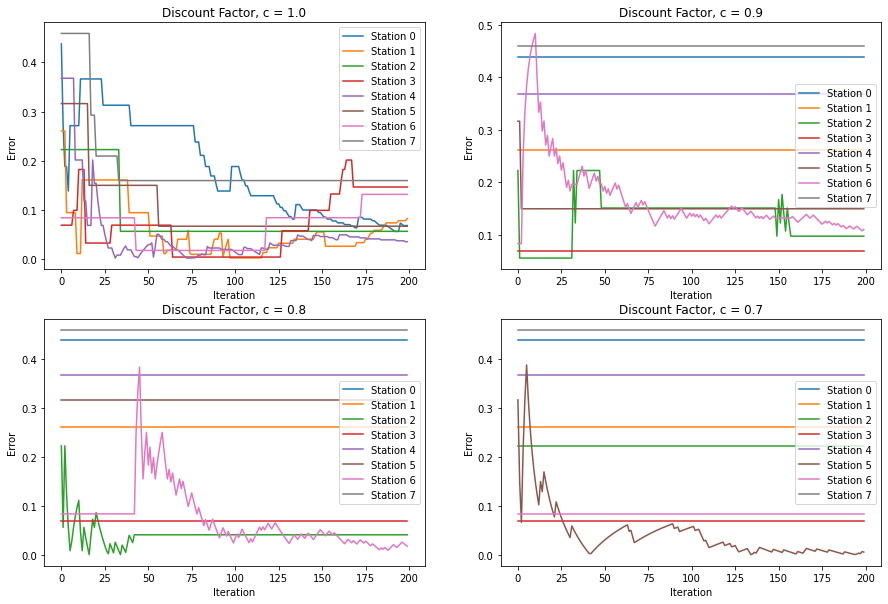

In [29]:
x = int(num_c/2)
labels = get_station_labels(num_stations)
fig, ax = plt.subplots(x, x, figsize=(15, 10))
k = 0
for i in range(x):
  for j in range(x):
    ax[i, j].plot(error[k])
    ax[i, j].legend(labels)
    ax[i, j].set_xlabel('Iteration')
    ax[i, j].set_ylabel('Error')
    ax[i, j].set_title(f'Discount Factor, c = {c_vals[k]}')
    k = k + 1

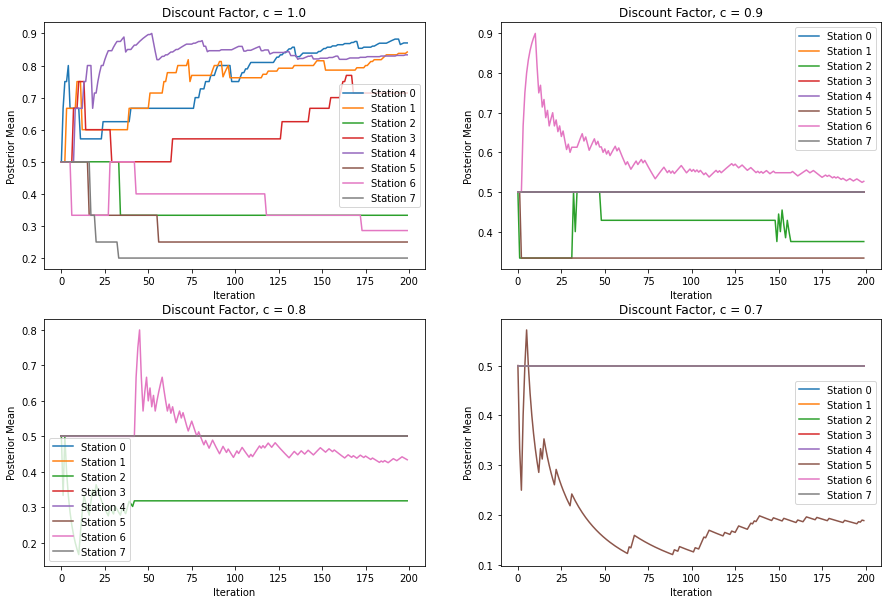

In [30]:
fig, ax = plt.subplots(x, x, figsize=(15, 10))
k = 0
for i in range(x):
  for j in range(x):
    ax[i, j].plot(posterior_means[k])
    ax[i, j].legend(labels)
    ax[i, j].set_xlabel('Iteration')
    ax[i, j].set_ylabel('Posterior Mean')
    ax[i, j].set_title(f'Discount Factor, c = {c_vals[k]}')
    k = k + 1

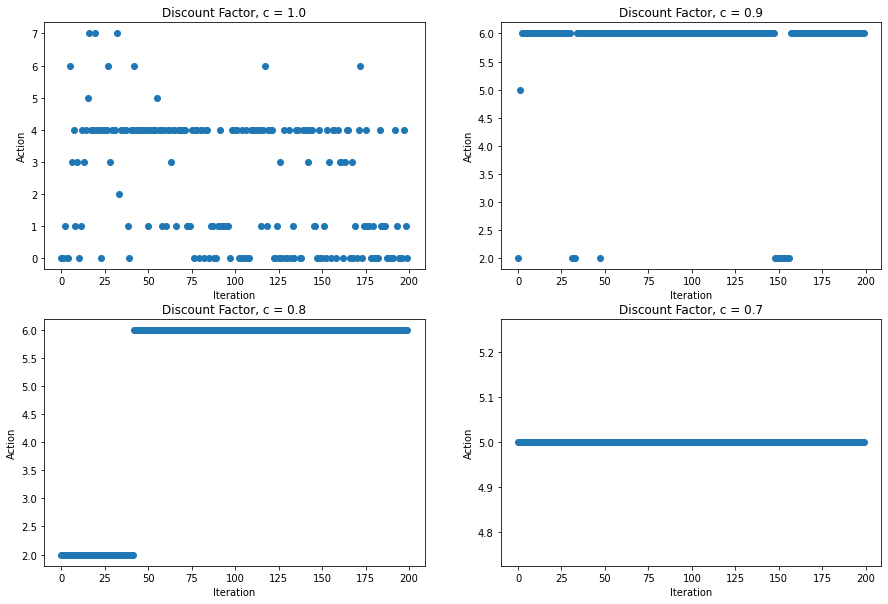

In [31]:
fig, ax = plt.subplots(x, x, figsize=(15, 10))
k = 0
for i in range(x):
  for j in range(x):
    ax[i, j].scatter(np.arange(num_iters), actions[k])
    ax[i, j].set_xlabel('Iteration')
    ax[i, j].set_ylabel('Action')
    ax[i, j].set_title(f'Discount Factor, c = {c_vals[k]}')
    k = k + 1